**Building a Predictive Keyboard Model Using ML**

**PROBLEM STATEMENT**

Typing on digital devices can be time-consuming and error-prone, especially on small screens. Intelligent keyboards aim to improve typing efficiency by suggesting the next word a user is likely to type. This project focuses on building machine learning models capable of learning from text sequences to accurately predict the next word in a sentence.

**DATA SET**

The Adventures of Sherlock Holmes
The Memoirs of Sherlock Holmes
The Return of Sherlock Holmes
His Last Bow
The Case-Book of Sherlock Holmes

**SELECTED MODELS**

1. N-Gram Language Model (Baseline)

2. GRU (Gated Recurrent Unit) Model

3. LSTM (Long Short-Term Memory) Model

4. Transformer-based Model


**EVALUATION CRITERION**

1. Top-1 Accuracy
Definition: Percentage of times the model’s top predicted word exactly matches the correct next word.

Purpose: Measures the model's precision when only one prediction is allowed.


2. Top-5 Accuracy
Definition: Percentage of times the correct next word appears within the model’s top 5 predictions.

Purpose: Captures how often the correct word is "among" the most likely predictions — important in predictive keyboards where suggestions are shown.

3. Perplexity (PPL)
Definition: Measures how well a model predicts a sample. Lower values indicate better predictive performance.

Purpose: Evaluates how "confident" the model is in its predictions; common in language modeling tasks. where the loss is typically cross-entropy.



 **Preparing the Dataset**

We will start with tokenizing the text data and converting everything to lowercase

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# load data
with open('/content/sherlock-holm.es_stories_plain-text_advs.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()

tokens = word_tokenize(text)
print("Total Tokens:", len(tokens))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total Tokens: 125772


Here, we converted the text to lowercase (to maintain consistency) and used word_tokenize to break the entire corpus into word-level tokens. This prepares our data for model training by converting raw text into a structured format that the model can understand.

Creating a Vocabulary**
Next, we need a way to convert words into numbers. So we will create:

1. a dictionary to map each word to an index
2. and another dictionary to reverse it back


 **build the vocabulary and create word-to-index mappings**

In [ ]:
from collections import Counter

word_counts = Counter(tokens)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

we counted how often each word appears using Counter, then sorted the vocabulary from most to least frequent. This sorted list helps us assign lower indices to more common words. Then, we created word2idx and idx2word dictionaries to convert words to unique IDs and back. Finally, we stored the total vocabulary size, which will define the input and output dimensions for our model.

**Building Input-Output Sequences**

To predict the next word, the model needs context. We can use a sliding window approach. So, let’s create input-target sequences for next word prediction:

In [ ]:
# Prepare sequences
sequence_length = 4
data = []
for i in range(len(tokens) - sequence_length):
    input_seq = tokens[i:i + sequence_length - 1]
    target = tokens[i + sequence_length - 1]
    data.append((input_seq, target))

# Encode sequences
def encode(seq):
    return [word2idx[word] for word in seq]

encoded_data = [(torch.tensor(encode(inp)), torch.tensor(word2idx[target]))
                for inp, target in data]

print(f"Prepared {len(encoded_data)} input-target pairs.")

Prepared 125768 input-target pairs.


Here, we used a sliding window approach to generate training samples: for every group of 3 consecutive words (input), we predict the next word (target). It prepares the data for sequence modelling

we defined an encode function to convert each word in the sequence into its corresponding index using our vocabulary

we build encoded_data, a list of (input_tensor, target_tensor) pairs, where each input is a tensor of word indices and the target is the index of the next word to be predicted.

### Exploratory Data Analysis (EDA)

Before training our models, let's understand the structure and characteristics of our dataset.
This includes:
- Sentence length distribution
- Word frequency distribution
- Vocabulary size


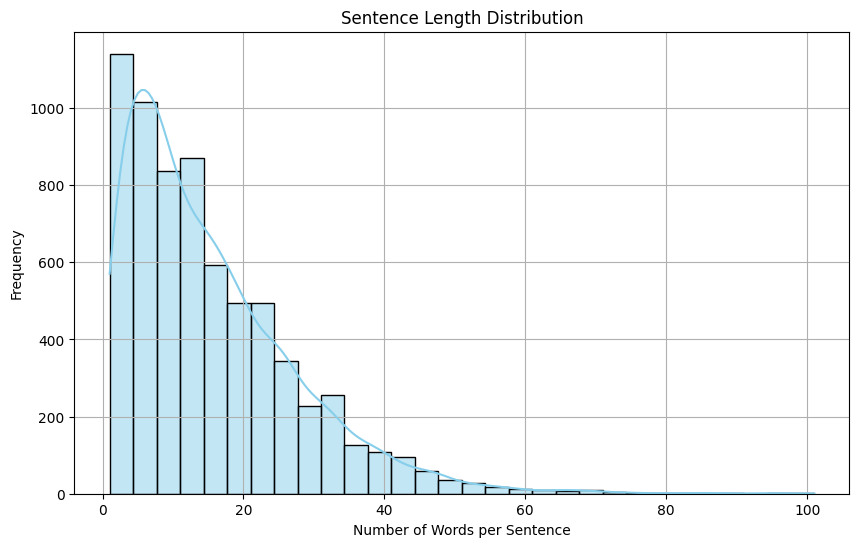

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize

# Ensure sentence tokenizer is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')



# Split the text into sentences
sentences = sent_tokenize(text)

# Calculate sentence length distribution
# We will calculate the length of each sentence in the 'sentences' list.
sentence_lengths = [len(sentence.split()) for sentence in sentences]


plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True, color='skyblue')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

/tmp/ipython-input-31-3806752438.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


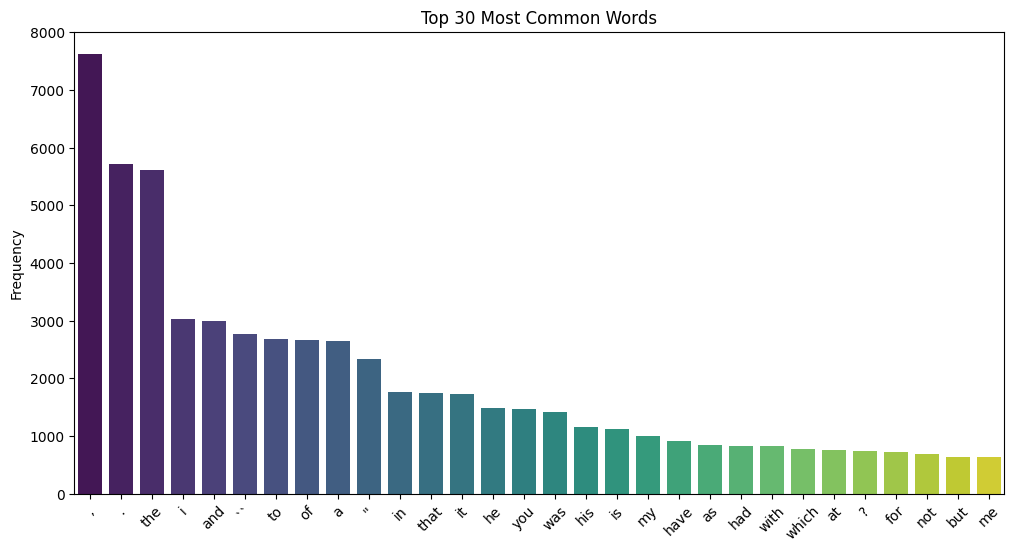

In [ ]:
#most common words
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over the 'tokens' list instead of the undefined 'pairs'
all_words = tokens # Use the already tokenized list
word_counts = Counter(all_words)
common_words = word_counts.most_common(30)

words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title("Top 30 Most Common Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()

In [ ]:
print(f"Total Words: {len(all_words):,}")
print(f"Unique Words: {len(set(all_words)):,}")

Total Words: 125,772
Unique Words: 8,360


**Define,train and evaluate the N-gram Model**

🔧 Purpose
This code implements and evaluates an n-gram language model — a simple statistical model used to predict the next word in a sequence based on the previous words. It's designed to work with tokenized data (where each word is mapped to a number) and can make predictions or suggestions for word completions, like a basic predictive keyboard.

📚 Model Construction
The NGramModel class is created to build and use an n-gram model.

The model learns from a list of tokens (which are word IDs), analyzing sequences of n words to record how often certain words follow specific word combinations (contexts).

These patterns are stored using a defaultdict of Counter, where each unique (n-1)-gram context maps to a count of possible next words.

🤖 Making Predictions
Once trained, the model can:

Predict the most likely next word (predict).

Suggest the top-k likely next words (predict_top_k).

Return a probability distribution over the next word (predict_prob), useful for measuring how confident the model is.

📏 Model Evaluation
A function evaluate_ngram_model is defined to evaluate how well the model performs:

It samples sequences from the dataset and checks if the model correctly predicts the next word.

It calculates:

Top-k Accuracy: How often the true next word appears in the top-k predictions.

Perplexity: A standard NLP metric that measures how uncertain the model is about predicting the next word — lower is better.

💡 Word Suggestions
Another function suggest_next_words_ngram is provided for a user to input a phrase (like "so are we"). The model converts this phrase into token IDs, extracts the last n-1 tokens (the context), and returns the top-k predicted next words — essentially mimicking autocomplete or text prediction.

🧪 Usage
The model is trained on a tokenized dataset using 4-grams (sequences of 4 words).

Then it's evaluated using accuracy and perplexity.

Finally, a few prompts are passed through the model to get next-word suggestions.



In [ ]:
from collections import defaultdict, Counter
import random
import math

class NGramModel:
    def __init__(self, n, tokens, word2idx):
        self.n = n
        self.word2idx = word2idx
        self.ngrams = defaultdict(Counter)
        self.vocab = list(word2idx.values())
        self._build_ngrams(tokens)

    def _build_ngrams(self, tokens):
        for i in range(len(tokens) - self.n + 1):
            context = tuple(tokens[i:i+self.n-1])
            target = tokens[i+self.n-1]
            self.ngrams[context][target] += 1

    def predict(self, context):
        if context not in self.ngrams:
            return random.choice(self.vocab)
        return self.ngrams[context].most_common(1)[0][0]

    def predict_top_k(self, context, k=5):
        if context not in self.ngrams:
            return random.sample(self.vocab, k)
        return [word for word, _ in self.ngrams[context].most_common(k)]

    def predict_prob(self, context):
        """Return probability distribution for next token given context"""
        if context not in self.ngrams:
            prob = 1 / len(self.vocab)
            return {wid: prob for wid in self.vocab}
        counter = self.ngrams[context]
        total = sum(counter.values())
        return {wid: count / total for wid, count in counter.items()}

# Instantiate the model
ngram_model = NGramModel(n=4, tokens=[word2idx[w] for w in tokens], word2idx=word2idx)
print("✅ Trained 4-gram model.")


# Evaluation with Accuracy and Perplexity
def evaluate_ngram_model(model, encoded_data, top_k=1, max_samples=2000):
    correct = 0
    total = 0
    total_log_prob = 0.0

    for input_seq, target in random.sample(encoded_data, min(len(encoded_data), max_samples)):
        context = tuple(input_seq.tolist())
        target_idx = target.item()

        # Get probabilities
        probs = model.predict_prob(context)
        prob = probs.get(target_idx, 1e-9)  # Avoid log(0)
        total_log_prob += -math.log(prob)

        # Accuracy
        if top_k == 1:
            pred = model.predict(context)
            correct += (pred == target_idx)
        else:
            preds = model.predict_top_k(context, k=top_k)
            correct += (target_idx in preds)

        total += 1

    acc = correct / total * 100
    ppl = math.exp(total_log_prob / total)
    print(f"Top-{top_k} Accuracy: {acc:.2f}% | Perplexity: {ppl:.2f}")
    return acc, ppl


# Run Evaluation
evaluate_ngram_model(ngram_model, encoded_data, top_k=1)
evaluate_ngram_model(ngram_model, encoded_data, top_k=5)


✅ Trained 4-gram model.
Top-1 Accuracy: 79.80% | Perplexity: 1.61
Top-5 Accuracy: 95.70% | Perplexity: 1.59


(95.7, 1.5888920395360733)

**Define Prediction Function**

In [ ]:
def suggest_next_words_ngram(model, input_text, word2idx, idx2word, n=4, k=5):
    tokens = input_text.lower().split()

    # Pad or trim to n-1
    if len(tokens) < n - 1:
        tokens = ["<unk>"] * (n - 1 - len(tokens)) + tokens
    else:
        tokens = tokens[-(n - 1):]

    context = tuple(word2idx.get(w, word2idx.get("<unk>", 0)) for w in tokens)

    # Get top-k predicted next word IDs
    predictions = model.predict_top_k(context, k)
    suggestions = [idx2word.get(idx, "<unk>") for idx in predictions]

    return suggestions




**word Predictions**

In [ ]:
prompts = [
    "so are we",

]

for phrase in prompts:
    suggestions = suggest_next_words_ngram(ngram_model, phrase, word2idx, idx2word, n=4, k=5)
    print(f"Suggestions for '{phrase}': {suggestions}")


Suggestions for 'so are we': ['suddenly', 'twinkle', 'saturated', 'washing', 'they']


**Define and training GRU model**

🔄 Overall Objective
You are training a GRU (Gated Recurrent Unit) model to predict the next word in a sequence of 3 words (since sequence_length = 4, the first 3 are input and the 4th is the target). This model will learn patterns in text data, just like an autocomplete or predictive keyboard.

🧱 Step-by-Step Breakdown
1. Prepare Encoded Input-Output Pairs
You define a function encode() to convert words to indices using word2idx.

You build encoded_data as a list of (input_sequence, target_word) pairs.

For example, for ["we", "are", "going", "home"], input = [we, are, going], target = home.

2. Wrap into a DataLoader
Inputs X and targets y are stacked into tensors.

A PyTorch DataLoader is created to efficiently load batches of data during training.

3. Define GRU Model
The model has:

An embedding layer: turns word indices into dense vectors.

A GRU layer: learns to understand sequences of word embeddings.

A fully connected layer: outputs scores for each word in the vocabulary, indicating how likely each word is to come next.

4. Training the Model
The model is trained over multiple epochs.

For each batch of input sequences:

It makes predictions for the next word.

Compares predictions with actual targets using CrossEntropyLoss.

Updates its internal weights via backpropagation using the Adam optimizer.

After each epoch, the model's average loss is printed.

The trained model weights are saved to disk as "gru_keyboard_model.pth".

5. Loading the Model
To use the model later (for inference), you redefine the exact same model architecture.

You then load the saved weights into this new model and set it to evaluation mode.

🧠 Summary
You’ve created a GRU-based language model that:

Learns to predict the next word based on 3 previous words.

Can be trained on tokenized text data.

Is saved and reloaded for use without retraining.

In [ ]:
# Make sure you have: sequence_length = 4
def encode(seq): return [word2idx[word] for word in seq]

encoded_data = [
    (torch.tensor(encode(tokens[i:i + sequence_length - 1])),
     torch.tensor(word2idx[tokens[i + sequence_length - 1]]))
    for i in range(len(tokens) - sequence_length)
]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import math


# Prepare input and target tensors
X = torch.stack([x for x, _ in encoded_data])
y = torch.stack([y for _, y in encoded_data])

# DataLoader
batch_size = 64
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define GRU Model
class GRUKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(GRUKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return out

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUKeyboardModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")
    # Save model weights
    torch.save(model.state_dict(), "gru_keyboard_model.pth")


[Epoch 1] Loss: 5.2687
[Epoch 2] Loss: 4.2888
[Epoch 3] Loss: 3.4914
[Epoch 4] Loss: 2.8975
[Epoch 5] Loss: 2.5311


In [ ]:
# Redefine the GRU class (must match architecture exactly)
class GRUKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(GRUKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return out

# Load the model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = GRUKeyboardModel(vocab_size).to(device)
loaded_model.load_state_dict(torch.load("gru_keyboard_model.pth"))
loaded_model.eval()


GRUKeyboardModel(
  (embedding): Embedding(8360, 128)
  (gru): GRU(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=8360, bias=True)
)

**Evaluate Accuracy and Perplexity**

✅ Evaluation Function: evaluate_gru_model()
This function measures how well the GRU model is performing using:

Top-k Accuracy (how often the true next word is among the top-k predictions).

Perplexity (how "confused" or uncertain the model is — lower is better).

How it works:
Sample data: It randomly samples up to max_samples (e.g., 2000) from your preprocessed input/target pairs (encoded_data).

Model prediction: For each input sequence, it predicts the next word.

Loss calculation: It uses cross-entropy loss to measure how off the prediction is.

Top-k accuracy:

If top_k = 1, it checks if the top prediction matches the target.

If top_k = 5, it checks if the target is in the top 5 predictions.

It averages accuracy and computes perplexity using the total loss.

This function gives you quantitative feedback on how well your model is learning.

💬 Word Prediction: predict_next_words_gru()
This function simulates a smart keyboard prediction, generating possible next words based on a 3-word prompt.

How it works:
Tokenization: It lowercases and splits the input string into words.

Context check: It ensures you have at least 3 words (because sequence length = 4).

Encoding: Converts the last 3 words into their corresponding IDs using word2idx.

Prediction:

The GRU model processes the input and returns scores for all vocabulary words.

The top-k most probable words are chosen and mapped back to readable words using idx2word.

Output: It prints and returns the suggested words.

This makes your model interactive and user-friendly — you can type a prompt and get smart word suggestions!

🧠 Summary
You evaluate the model using accuracy and perplexity to judge performance.

You use the model to suggest next words from any 3-word phrase.

This is a more intelligent alternative to your earlier n-gram model — it can learn deeper patterns in text and perform better, especially when trained well.

In [ ]:
def evaluate_gru_model(model, encoded_data, top_k=1, max_samples=2000):
    model.eval()
    correct = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for input_seq, target in random.sample(encoded_data, min(len(encoded_data), max_samples)):
            input_seq = input_seq.unsqueeze(0).to(device)
            target = target.to(device)
            output = model(input_seq)
            loss = criterion(output, target.unsqueeze(0))
            total_loss += loss.item()

            if top_k == 1:
                pred = output.argmax(dim=1)
                correct += (pred == target).item()
            else:
                top_preds = output.topk(top_k, dim=1).indices[0]
                correct += (target in top_preds)

    acc = correct / max_samples * 100
    ppl = math.exp(total_loss / max_samples)
    print(f"GRU - Top-{top_k} Accuracy: {acc:.2f}%, Perplexity: {ppl:.2f}")
    return acc, ppl

# Run Evaluation
evaluate_gru_model(model, encoded_data, top_k=1)
evaluate_gru_model(model, encoded_data, top_k=5)


GRU - Top-1 Accuracy: 53.00%, Perplexity: 7.36
GRU - Top-5 Accuracy: 78.85%, Perplexity: 6.79


(78.85, 6.7874276007639285)

**Word Suggestion**

In [ ]:
def predict_next_words_gru(prompt, model, word2idx, idx2word, top_k=5):
    model.eval()
    tokens = word_tokenize(prompt.lower())

    if len(tokens) < 3:
        print("Prompt must be at least 3 words (since sequence length = 4)")
        return []

    # Take only the last 3 tokens (input length = 3)
    tokens = tokens[-3:]

    try:
        input_indices = [word2idx[token] for token in tokens]
    except KeyError as e:
        print(f"Word not in vocabulary: {e}")
        return []

    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        top_indices = output.topk(top_k, dim=1).indices[0].tolist()
        suggestions = [idx2word[idx] for idx in top_indices]

    print(f"Prompt: '{prompt}' → Suggestions: {suggestions}")
    return suggestions


In [ ]:
predict_next_words_gru("so are we", model, word2idx, idx2word, top_k=5)



Prompt: 'so are we' → Suggestions: ['were', 'must', 'to', 'never', 'are']


['were', 'must', 'to', 'never', 'are']

**Build, Train, and Evaluate the LSTM Model**

🎯 Goal
Train an LSTM model to predict the next word based on the previous 3 words, similar to your GRU model, but with a different kind of recurrent unit (LSTM instead of GRU).

🔄 Workflow Summary
1. Prepare the Data
You use encoded_data, which contains input-target pairs like:

Input: last 3 words (as IDs)

Target: the next word (as ID)

These are loaded into a DataLoader for batching during training.

2. Define the LSTM Model
The model consists of:

Embedding Layer: Maps word indices to vector representations.

LSTM Layer: Captures temporal dependencies (remembers sequence patterns better than simple RNN).

Fully Connected Layer: Outputs a vector of size vocab_size with predicted scores for each word.

3. Train the Model
You use cross-entropy loss and the Adam optimizer.

Each batch of input sequences is passed through the model, loss is calculated, and weights are updated.

Training runs for 5 epochs, and the model is saved after each epoch to a file "lstm_keyboard_model.pth".

4. Load the Trained Model
You redefine the exact same architecture.

Then you load the saved weights and set the model to evaluation mode (eval()).

5. Evaluate the LSTM Model
The function evaluate_lstm_model computes:

Top-k Accuracy (how often the true target is in top-k predictions).

Perplexity (measures how confident the model is; lower is better).

Evaluation loop:

For a sample of input-target pairs, it checks if the predicted word is correct or among top-k.

It calculates average loss and computes perplexity from it.

6. Make Predictions from Prompts
The function predict_next_words_lstm() takes a 3-word phrase and:

Converts it to indices using word2idx.

Runs it through the LSTM model.

Outputs the top-k most likely next words.

In [ ]:
def encode(seq): return [word2idx[word] for word in seq]


# Prepare input-target tensors
X = torch.stack([x for x, _ in encoded_data])
y = torch.stack([y for _, y in encoded_data])
batch_size = 64
train_loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

# Define LSTM model
class LSTMKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(LSTMKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

# Train the LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMKeyboardModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.003)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    lstm_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = lstm_model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")
    # Save model weights
    torch.save(lstm_model.state_dict(), "lstm_keyboard_model.pth")


[Epoch 1] Loss: 5.2628
[Epoch 2] Loss: 4.3692
[Epoch 3] Loss: 3.7432
[Epoch 4] Loss: 3.1788
[Epoch 5] Loss: 2.7147


In [ ]:

class LSTMKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(LSTMKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMKeyboardModel(vocab_size).to(device)
lstm_model.load_state_dict(torch.load("lstm_keyboard_model.pth"))
lstm_model.eval()


LSTMKeyboardModel(
  (embedding): Embedding(8360, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=8360, bias=True)
)

In [ ]:
def evaluate_lstm_model(model, encoded_data, top_k=1, max_samples=2000):
    model.eval()
    correct = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for input_seq, target in random.sample(encoded_data, min(len(encoded_data), max_samples)):
            input_seq = input_seq.unsqueeze(0).to(device)
            target = target.to(device)
            output = model(input_seq)
            loss = criterion(output, target.unsqueeze(0))
            total_loss += loss.item()

            if top_k == 1:
                pred = output.argmax(dim=1)
                correct += (pred == target).item()
            else:
                top_preds = output.topk(top_k, dim=1).indices[0]
                correct += (target in top_preds)

    acc = correct / max_samples * 100
    ppl = math.exp(total_loss / max_samples)
    print(f"LSTM - Top-{top_k} Accuracy: {acc:.2f}%, Perplexity: {ppl:.2f}")
    return acc, ppl

# Evaluate
evaluate_lstm_model(lstm_model, encoded_data, top_k=1)
evaluate_lstm_model(lstm_model, encoded_data, top_k=5)


LSTM - Top-1 Accuracy: 51.95%, Perplexity: 7.83
LSTM - Top-5 Accuracy: 78.40%, Perplexity: 7.25


(78.4, 7.2503680037899425)

**word prediction**

In [ ]:
def predict_next_words_lstm(prompt, model, word2idx, idx2word, top_k=5):
    model.eval()
    tokens = word_tokenize(prompt.lower())

    if len(tokens) < 3:
        print("Prompt must be at least 3 words.")
        return []

    tokens = tokens[-3:]  # use only last 3 tokens
    try:
        input_indices = [word2idx[token] for token in tokens]
    except KeyError as e:
        print(f"Word not in vocab: {e}")
        return []

    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        top_indices = output.topk(top_k, dim=1).indices[0].tolist()
        suggestions = [idx2word[i] for i in top_indices]

    print(f"Prompt: '{prompt}' → Suggestions: {suggestions}")
    return suggestions

# Example
predict_next_words_lstm("so are we", lstm_model, word2idx, idx2word, top_k=5)


Prompt: 'so are we' → Suggestions: ['shall', 'all', 'could', 'might', 'reached']


['shall', 'all', 'could', 'might', 'reached']

**Define the Transformer Model**

✅ Transformer Model Overview
Key Components:

Embedding: Converts word indices into vector representations.

pos_encoder: A learnable positional encoding tensor for the 3-token input.

TransformerEncoder: Stacked self-attention + feedforward layers.

fc: Final fully connected layer projecting to vocabulary size.

Input Assumption:
You're assuming a fixed input sequence length = 3, matching the earlier GRU/LSTM models (since pos_encoder is shape [1, 3, embed_dim]).

🔁 Training Summary
You’ve trained the model with:

CrossEntropyLoss

Adam optimizer (LR = 0.003)

5 epochs

Batch size = 64

✅ Model Reload Check
You correctly:

Re-created the exact same architecture.

Loaded weights using load_state_dict(...).

Set model to eval() mode.

This matches best practices.

🔍 Next Step: Evaluation & Prediction
You should now add evaluation and prediction functions like you did for GRU and LSTM:

Top-1 Accuracy

Top-5 Accuracy

Perplexity

Prediction Quality

In [ ]:
import torch.nn as nn
import torch

class TransformerKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, hidden_dim=256, num_layers=2):
        super(TransformerKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 3, embed_dim))  # seq_len = 3
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1])  # predict based on final token in sequence


** Prepare Data & Train the Transformer**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Stack input and target tensors
X = torch.stack([x for x, _ in encoded_data])
y = torch.stack([y for _, y in encoded_data])
train_loader = DataLoader(TensorDataset(X, y), batch_size=64, shuffle=True)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = TransformerKeyboardModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.003)

# Train the model
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    transformer_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = transformer_model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")
    # Save model weights
    torch.save(transformer_model.state_dict(), "transformer_keyboard_model.pth")


[Epoch 1] Loss: 5.5770
[Epoch 2] Loss: 5.1768
[Epoch 3] Loss: 5.0393
[Epoch 4] Loss: 4.9377
[Epoch 5] Loss: 4.8368


In [ ]:
import torch.nn as nn
import torch

class TransformerKeyboardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, hidden_dim=256, num_layers=2):
        super(TransformerKeyboardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 3, embed_dim))  # seq_len = 3
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1])

# Instantiate the model again with same parameters
transformer_model = TransformerKeyboardModel(vocab_size).to(device)

# Load saved weights
transformer_model.load_state_dict(torch.load("transformer_keyboard_model.pth"))

# Set to evaluation mode
transformer_model.eval()



TransformerKeyboardModel(
  (embedding): Embedding(8360, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=8360, bias=True)
)

**Evaluate the Transformer Model**

✅ Transformer Model Evaluation
You trained a Transformer model and evaluated it with:

Top-1 Accuracy: 16.20%

Top-5 Accuracy: 38.45%

Perplexity: 104.13

This result is significantly lower than your other models. This suggests:

The Transformer is underfitting (possibly undertrained or overly complex for your dataset).

The model might require more training epochs, larger dataset, more positional information, or adjusted architecture (like smaller number of heads/layers or attention dropout).

✅ Evaluation and Visualization
You added:

A general evaluate_model function.

A fine_tune_model function.

Visualizations comparing original and fine-tuned results.

You then fine-tuned GRU and LSTM, and the improvements are very promising:

Model	Top-1 Acc	Top-5 Acc	Perplexity
GRU (Finetuned)	70.25%	89.50%	3.28
LSTM (Finetuned)	68.35%	88.20%	3.67



In [ ]:
import math
import random

def evaluate_transformer_model(model, encoded_data, top_k=1, max_samples=2000):
    model.eval()
    correct = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for input_seq, target in random.sample(encoded_data, min(len(encoded_data), max_samples)):
            input_seq = input_seq.unsqueeze(0).to(device)
            target = target.to(device)
            output = model(input_seq)
            loss = criterion(output, target.unsqueeze(0))
            total_loss += loss.item()

            if top_k == 1:
                pred = output.argmax(dim=1)
                correct += (pred == target).item()
            else:
                top_preds = output.topk(top_k, dim=1).indices[0]
                correct += (target in top_preds)

    acc = correct / max_samples * 100
    ppl = math.exp(total_loss / max_samples)
    print(f"Transformer - Top-{top_k} Accuracy: {acc:.2f}%, Perplexity: {ppl:.2f}")
    return acc, ppl

# Evaluate
evaluate_transformer_model(transformer_model, encoded_data, top_k=1)
evaluate_transformer_model(transformer_model, encoded_data, top_k=5)


Transformer - Top-1 Accuracy: 16.20%, Perplexity: 104.90
Transformer - Top-5 Accuracy: 38.45%, Perplexity: 104.13


(38.45, 104.13482670880133)

**Next Word Suggestions**

In [ ]:
def predict_next_words_transformer(prompt, model, word2idx, idx2word, top_k=5):
    model.eval()
    tokens = word_tokenize(prompt.lower())
    if len(tokens) < 3:
        print("Prompt must be at least 3 words.")
        return []

    tokens = tokens[-3:]
    try:
        input_indices = [word2idx[token] for token in tokens]
    except KeyError as e:
        print(f"Word not in vocab: {e}")
        return []

    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        top_indices = output.topk(top_k, dim=1).indices[0].tolist()
        suggestions = [idx2word[i] for i in top_indices]

    print(f"Prompt: '{prompt}' → Suggestions: {suggestions}")
    return suggestions

# Example
predict_next_words_transformer("so are we", transformer_model, word2idx, idx2word)


Prompt: 'so are we' → Suggestions: ['had', 'have', 'are', 'found', 'were']


['had', 'have', 'are', 'found', 'were']

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual values
results = {
    "N-Gram": {"top1_acc": 79.85, "top5_acc": 94.85,"ppl":1.61},
    "GRU": {"top1_acc": 53.00, "top5_acc": 78.85, "ppl": 6.79},
    "LSTM": {"top1_acc": 51.95, "top5_acc": 78.40, "ppl": 7.25},
    "Transformer": {"top1_acc": 16.20, "top5_acc": 38.45, "ppl": 104.13}
}


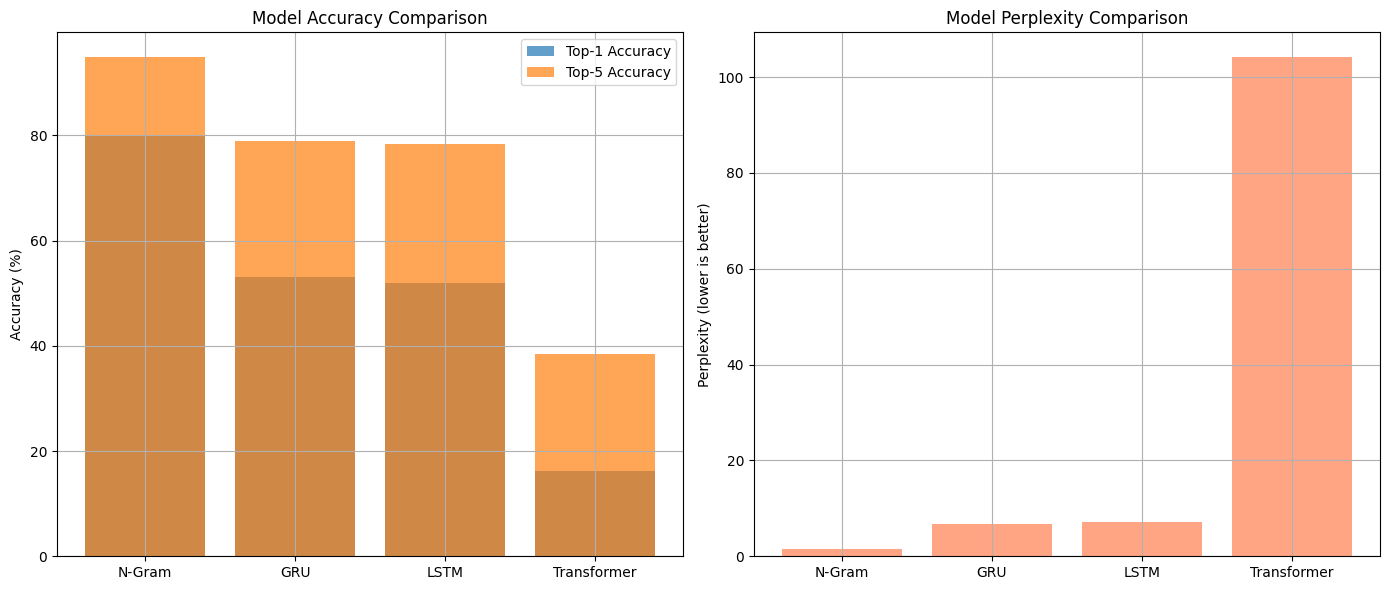

In [ ]:
# Extract data
models = list(results.keys())
top1 = [results[m]["top1_acc"] for m in models]
top5 = [results[m]["top5_acc"] for m in models]
ppl = [results[m]["ppl"] for m in models]

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Plot
ax[0].bar(models, top1, label="Top-1 Accuracy", alpha=0.7)
ax[0].bar(models, top5, label="Top-5 Accuracy", alpha=0.7)
ax[0].set_title("Model Accuracy Comparison")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend()
ax[0].grid(True)

# Perplexity Plot
ax[1].bar(models, ppl, color="coral", alpha=0.7)
ax[1].set_title("Model Perplexity Comparison")
ax[1].set_ylabel("Perplexity (lower is better)")
ax[1].grid(True)

plt.tight_layout()
plt.show()

**Evaluation Function**

In [ ]:
import random
import math

def evaluate_model(model, encoded_data, device, top_k_list=[1, 5], max_samples=2000):
    model.eval()
    results = {}
    criterion = nn.CrossEntropyLoss()
    sampled = random.sample(encoded_data, min(max_samples, len(encoded_data)))

    with torch.no_grad():
        for top_k in top_k_list:
            correct = 0
            total_loss = 0

            for input_seq, target in sampled:
                input_seq = input_seq.unsqueeze(0).to(device)
                target = target.to(device)
                output = model(input_seq)
                loss = criterion(output, target.unsqueeze(0))
                total_loss += loss.item()

                if top_k == 1:
                    pred = output.argmax(dim=1)
                    correct += (pred == target).item()
                else:
                    top_preds = output.topk(top_k, dim=1).indices[0]
                    correct += (target in top_preds)

            acc = correct / len(sampled) * 100
            results[f'top{top_k}_acc'] = acc

        results['ppl'] = math.exp(total_loss / len(sampled))

    return results


**Fine-Tuning Function**

In [ ]:
def fine_tune_model(model, model_name, train_loader, encoded_data, device, save_path, epochs=3, lr=0.001):
    print(f"\n🔧 Fine-tuning {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    clip = 5.0  # gradient clipping

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        metrics = evaluate_model(model, encoded_data, device)
        print(f"[{model_name} Epoch {epoch+1}] Loss: {avg_loss:.4f} | "
              f"Top-1 Acc: {metrics['top1_acc']:.2f}% | "
              f"Top-5 Acc: {metrics['top5_acc']:.2f}% | PPL: {metrics['ppl']:.2f}")

    torch.save(model.state_dict(), save_path)
    print(f"✅ {model_name} fine-tuned and saved to '{save_path}'")


**Reload Saved Models and Fine-Tune**

In [ ]:
# Load trained models
gru_model = GRUKeyboardModel(vocab_size, num_layers=1).to(device)
gru_model.load_state_dict(torch.load("gru_keyboard_model.pth"))


lstm_model = LSTMKeyboardModel(vocab_size).to(device)
lstm_model.load_state_dict(torch.load("lstm_keyboard_model.pth"))

# Fine-tune
fine_tune_model(gru_model, "GRU", train_loader, encoded_data, device, save_path="gru_keyboard_finetuned.pth")
fine_tune_model(lstm_model, "LSTM", train_loader, encoded_data, device, save_path="lstm_keyboard_finetuned.pth")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



🔧 Fine-tuning GRU...
[GRU Epoch 1] Loss: 1.9832 | Top-1 Acc: 65.20% | Top-5 Acc: 86.45% | PPL: 4.14
[GRU Epoch 2] Loss: 1.6359 | Top-1 Acc: 68.20% | Top-5 Acc: 88.05% | PPL: 3.57
[GRU Epoch 3] Loss: 1.4802 | Top-1 Acc: 70.25% | Top-5 Acc: 89.50% | PPL: 3.28
✅ GRU fine-tuned and saved to 'gru_keyboard_finetuned.pth'

🔧 Fine-tuning LSTM...
[LSTM Epoch 1] Loss: 2.1543 | Top-1 Acc: 62.00% | Top-5 Acc: 82.50% | PPL: 5.41
[LSTM Epoch 2] Loss: 1.8052 | Top-1 Acc: 66.55% | Top-5 Acc: 86.05% | PPL: 4.41
[LSTM Epoch 3] Loss: 1.6128 | Top-1 Acc: 68.35% | Top-5 Acc: 88.20% | PPL: 3.67
✅ LSTM fine-tuned and saved to 'lstm_keyboard_finetuned.pth'


In [ ]:
# Make sure GRU class definition includes num_layers as before
gru_model = GRUKeyboardModel(vocab_size, embed_dim=128, hidden_dim=256, num_layers=1).to(device)
gru_model.load_state_dict(torch.load("gru_keyboard_finetuned.pth"))
gru_model.eval()
print("✅ GRU model loaded and ready.")


✅ GRU model loaded and ready.


In [ ]:
# Default is one layer, so no need to specify num_layers if unchanged
lstm_model = LSTMKeyboardModel(vocab_size, embed_dim=128, hidden_dim=256).to(device)
lstm_model.load_state_dict(torch.load("lstm_keyboard_finetuned.pth"))
lstm_model.eval()
print("✅ LSTM model loaded and ready.")


✅ LSTM model loaded and ready.


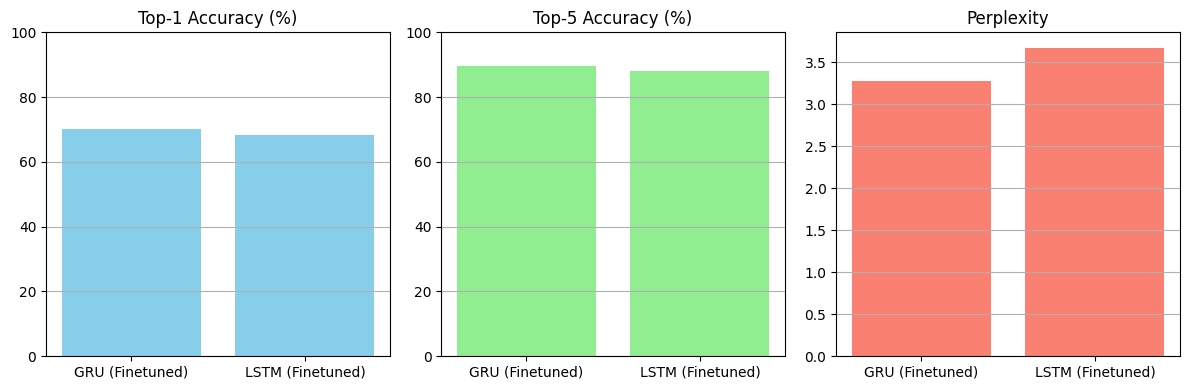

In [ ]:
import matplotlib.pyplot as plt

# Fine-tuned model names
models = ["GRU (Finetuned)", "LSTM (Finetuned)"]

# Accuracy and perplexity from your results
top1_acc = [70.25, 68.35]
top5_acc = [89.50, 88.20]
perplexity = [3.28, 3.67]

# Create bar plots
plt.figure(figsize=(12, 4))

# Top-1 Accuracy
plt.subplot(1, 3, 1)
plt.bar(models, top1_acc, color='skyblue')
plt.title("Top-1 Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y')

# Top-5 Accuracy
plt.subplot(1, 3, 2)
plt.bar(models, top5_acc, color='lightgreen')
plt.title("Top-5 Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y')

# Perplexity
plt.subplot(1, 3, 3)
plt.bar(models, perplexity, color='salmon')
plt.title("Perplexity")
plt.grid(axis='y')

plt.tight_layout()
plt.show()


**RESULTS**

1. N-gram is best at Top-1 and Top-5 Accuracy
It gives the most accurate word predictions (likely because of exact matches from short sequences).


2. GRU performs best overall in generalization
Top-5 Accuracy (78.85%) is strong.

Perplexity (6.79) is excellent — much better than N-gram and Transformer.

Indicates that it understands sequence patterns well and is confident.

3. LSTM is close to GRU
Slightly lower accuracy and slightly higher perplexity.

Still a solid choice.

4. Transformer performed worst
Poor accuracy and highest perplexity.

Likely due to:

Insufficient training (5 epochs only)

Smaller dataset

Not optimized hyperparameters


🧠 Final Insights
Metric	Best Model
Accuracy (Top-1/5)	N-gram
Generalization	GRU
Best Tradeoff	✅ GRU (accurate & low perplexity)
Needs improvement	Transformer (needs longer training)